In [2]:
import numpy as np
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
import yfinance as yf

DX = yf.Ticker("DX-Y.NYB")
raw_data = DX.history(period = 'max')['Close']
raw_data.tail()

Date
2021-08-31    92.629997
2021-09-01    92.449997
2021-09-02    92.230003
2021-09-03    92.040001
2021-09-06    92.251999
Name: Close, dtype: float64

<AxesSubplot:xlabel='Date'>

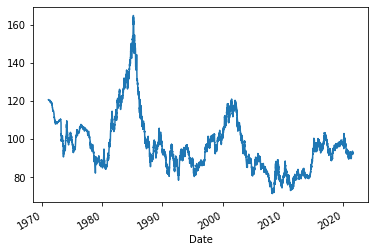

In [4]:
raw_data.plot()

In [48]:
def log_return(series):
    return np.log(series).diff()


In [53]:
raw_data = log_return(raw_data)[1::]

In [74]:
raw_data.min()

-0.05129333963229321

用create_seq將一個時間序列依想要訓練的長度  
拆成訓練資料與target  

In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length ):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [54]:
create_sequences(raw_data.loc['2021'::], 5)
#將每5天抓出來成為一個array 並用第6天的當成收盤價

(array([[-0.00066739, -0.00490738,  0.00100571,  0.00334526,  0.00300113],
        [-0.00490738,  0.00100571,  0.00334526,  0.00300113,  0.0048716 ],
        [ 0.00100571,  0.00334526,  0.00300113,  0.0048716 , -0.00542665],
        [ 0.00334526,  0.00300113,  0.0048716 , -0.00542665,  0.00299381],
        [ 0.00300113,  0.0048716 , -0.00542665,  0.00299381, -0.00088615],
        [ 0.0048716 , -0.00542665,  0.00299381, -0.00088615,  0.00596622],
        [-0.00542665,  0.00299381, -0.00088615,  0.00596622, -0.00308913],
        [ 0.00299381, -0.00088615,  0.00596622, -0.00308913, -0.00033153],
        [-0.00088615,  0.00596622, -0.00308913, -0.00033153, -0.00376528],
        [ 0.00596622, -0.00308913, -0.00033153, -0.00376528,  0.00121972],
        [-0.00308913, -0.00033153, -0.00376528,  0.00121972,  0.00166087],
        [-0.00033153, -0.00376528,  0.00121972,  0.00166087, -0.00243688],
        [-0.00376528,  0.00121972,  0.00166087, -0.00243688,  0.0053092 ],
        [ 0.00121972,  0.

In [55]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [75]:
class DX_dataset(Dataset):
    def __init__(self, data, mode = 'train'):
         
        #set data split
        test_date = '2021'
        start_train = '2010'
        end_train='2020'    
        self.seq_length = config['seq_length']

        self.mode = mode
        
        if self.mode == 'test': #就是test mode的情況下
            x,y = create_sequences(data.loc[test_date], self.seq_length)
            self.data = torch.FloatTensor(x)
            self.test_target = y # 用來評斷test的loss
        else: 
            # create sequence 
            x,y = create_sequences(data.loc[start_train:end_train], self.seq_length)
            
            sub_train_size = round(len(x)*0.8) #train_mode set 80% for training
            if self.mode == 'train':
                self.data = torch.FloatTensor(x[0:sub_train_size])
                self.target = torch.FloatTensor(y[0:sub_train_size])
            elif self.mode == 'vaildation':
                self.data = torch.FloatTensor(x[sub_train_size::])
                self.target = torch.FloatTensor(y[sub_train_size::])
            
            #self.target = \
            #(self.target - self.target.mean(dim=0, keepdim=True)) \
            #/ self.target.std(dim=0, keepdim=True)
        
        self.data = \
            (self.data - self.data.mean(dim=0, keepdim=True)) \
            / self.data.std(dim=0, keepdim=True)
        #取log diff 後 應該就不用在做標準化了
        

    def __getitem__(self, index):
        
        if self.mode in ['train', 'vaildation']:
            # For training
            return self.data[index].view(1,self.seq_length), self.target[index]
        else:
            # For testing (no target)
            return self.data[index].view(1,self.seq_length)
            
    def __len__(self): 
        # Returns the size of the dataset
        return len(self.data)

In [76]:
def prep_dataloader(data, mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = DX_dataset(data, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=True,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [77]:
#optimizer 用Adam
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 64,               # mini-batch size for dataloader
    'seq_length' : 14,
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        #'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200             # early stopping epochs (the number epochs since your model's last improvement) # your model will be saved here
}


In [134]:
#用來檢視input data的dim
#data = prep_dataloader(raw_data, mode= 'train',batch_size = 3)
#for x,y in data:
    #print(f'train_data: {x}, target : {y}')
    #print(f'train_data_shape : {x.shape}')

In [135]:
#用來試試看模型dim是否正確
model = Model(1)
test = torch.randn(3,1,14)
pred = model(test)
pred


tensor([[[ 0.0770]],

        [[ 0.0068]],

        [[-0.0141]]], grad_fn=<AddBackward0>)

In [136]:
torch.flatten(pred)

tensor([ 0.0770,  0.0068, -0.0141], grad_fn=<ViewBackward>)

In [85]:
#原本自己弄了一個naive的1d cnn 但效果很差 就直接把別人疊好的拿來用
class Conv1dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(5,), stride=(1,), padding=(2,)):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='replicate', bias=True),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='replicate', bias=True),
            nn.BatchNorm1d(out_channels),
        )
        self.activation = nn.ReLU()
        
    def forward(self, x):
        output = self.conv_block(x)
        output = self.activation(output)
        return output
    # with kernel_size & padding , can make sure length of output eqauals to input array
    
class Model(nn.Module):
     def __init__(self, in_channels):
        super().__init__()
        self.conv_block1 = Conv1dBlock(in_channels=in_channels, out_channels=32)
        self.conv_block6 = Conv1dBlock(in_channels=32, out_channels=16)
        self.conv_block7 = Conv1dBlock(in_channels=16, out_channels=8)
        self.conv_block8 = Conv1dBlock(in_channels=8, out_channels=1)
        self.pooling = nn.AvgPool1d(kernel_size=(3,), stride=(1,), padding=(1,))
        self.linear1 = nn.Linear(1 * 14  ,28) #out_dim * seq_length * batch_size
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(28,1)

        self.criterion = nn.MSELoss(reduction='mean')
     
     def forward(self, x):
        x = self.conv_block1(x)
        x = self.pooling(x)
        x = self.conv_block6(x)
        x = self.pooling(x)
        x = self.conv_block7(x)
        x = self.pooling(x)
        x = self.conv_block8(x)
        x = self.pooling(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x
    
     def cal_loss(self, pred, target):
        return self.criterion(pred, target)


In [88]:
#直接搬李鴻毅HW1的train過來改
def train(tr_set, dv_set, model, config):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero cleaning grad before
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.6f})'
                .format(epoch + 1, min_mse))
            #torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


def dev(dv_set, model):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

def test(tt_set, model):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds



In [89]:
#train 太慢跑不了 把batch調大雖然可以train 但不是我要的用14天資料去預測隔天
tr_set = prep_dataloader(raw_data, 'train', config['batch_size'])
dv_set = prep_dataloader(raw_data, 'vaildation', config['batch_size'])

model = Model(1)
model_loss, model_loss_record = train(tr_set, dv_set, model, config)

Saving model (epoch =    1, loss = 0.000230)
Saving model (epoch =    2, loss = 0.000101)
Saving model (epoch =    3, loss = 0.000064)
Saving model (epoch =    4, loss = 0.000047)
Saving model (epoch =    5, loss = 0.000040)
Saving model (epoch =    6, loss = 0.000036)
Saving model (epoch =    7, loss = 0.000031)
Saving model (epoch =    8, loss = 0.000031)
Saving model (epoch =    9, loss = 0.000027)
Saving model (epoch =   10, loss = 0.000026)
Saving model (epoch =   11, loss = 0.000024)
Saving model (epoch =   12, loss = 0.000024)
Saving model (epoch =   13, loss = 0.000022)
Saving model (epoch =   14, loss = 0.000022)
Saving model (epoch =   15, loss = 0.000021)
Saving model (epoch =   17, loss = 0.000020)
Saving model (epoch =   20, loss = 0.000019)
Saving model (epoch =   21, loss = 0.000019)
Saving model (epoch =   22, loss = 0.000019)
Saving model (epoch =   24, loss = 0.000018)
Saving model (epoch =   25, loss = 0.000018)
Saving model (epoch =   27, loss = 0.000018)
Saving mod

In [283]:
a = dv_set.dataset.data[10].view(1,1,14)
preds = model(a) 

In [90]:
tt_set = prep_dataloader(raw_data, 'test', config['batch_size'])
preds = test(tt_set, model)

In [104]:
tt_set.dataset.data.shape

torch.Size([157, 14])

In [106]:
len(tt_set)

2

<AxesSubplot:>

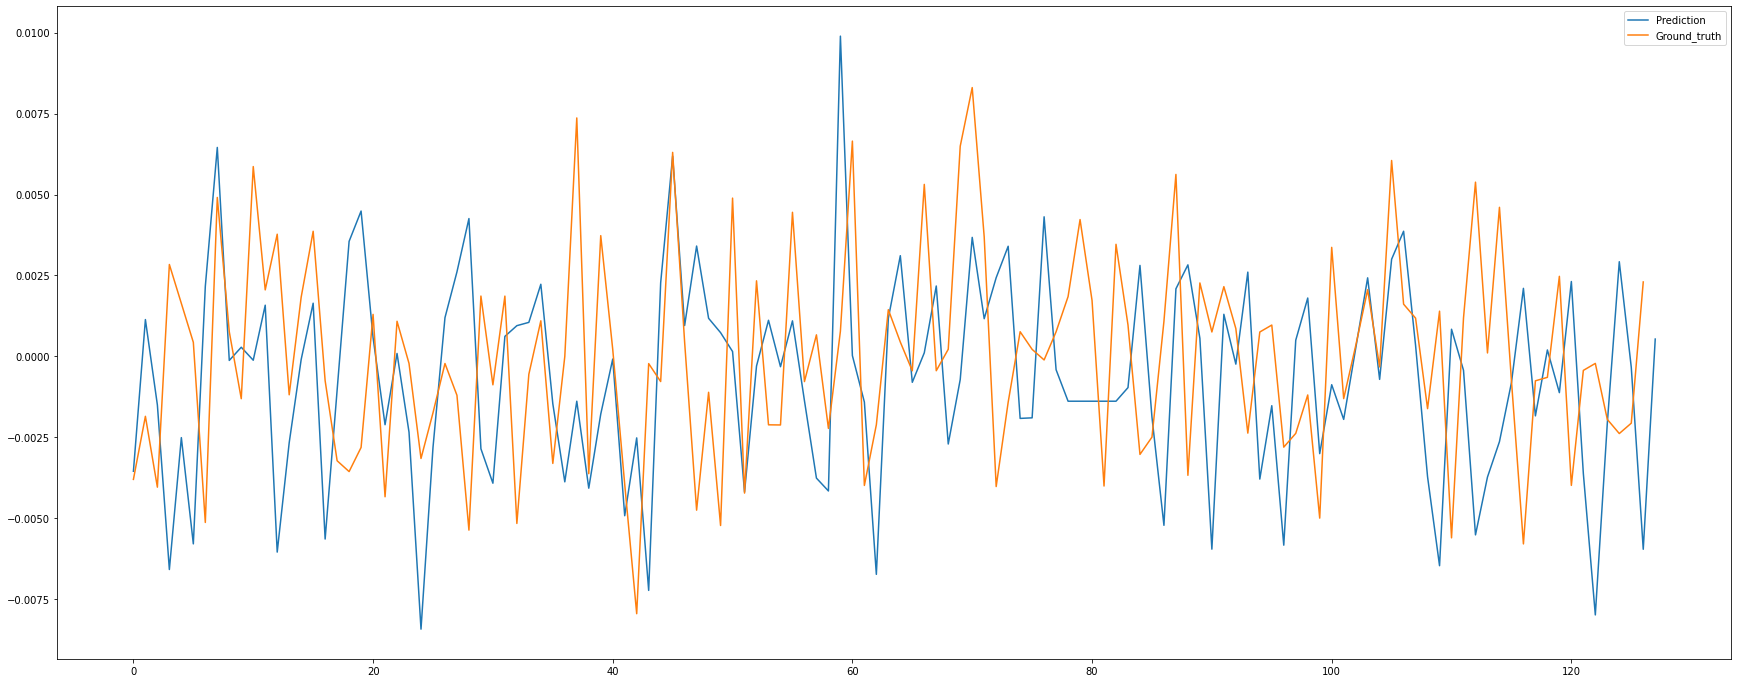

In [132]:
result = pd.DataFrame(preds, columns = {'Prediction'})
result['Ground_truth'] = raw_data.loc['2021'][44::].reset_index(drop = True)
result.plot(figsize = (30,12))

In [117]:
raw_data.loc['2021'][44::]

Date
2021-03-09   -0.003799
2021-03-10   -0.001850
2021-03-11   -0.004039
2021-03-12    0.002840
2021-03-15    0.001635
                ...   
2021-08-31   -0.000216
2021-09-01   -0.001945
2021-09-02   -0.002382
2021-09-03   -0.002062
2021-09-06    0.002301
Name: Close, Length: 127, dtype: float64

In [124]:
tmp_series = raw_data.loc['2021'][44::].reset_index(drop = True)
tmp_series

0     -0.003799
1     -0.001850
2     -0.004039
3      0.002840
4      0.001635
         ...   
122   -0.000216
123   -0.001945
124   -0.002382
125   -0.002062
126    0.002301
Name: Close, Length: 127, dtype: float64

<AxesSubplot:xlabel='Date'>

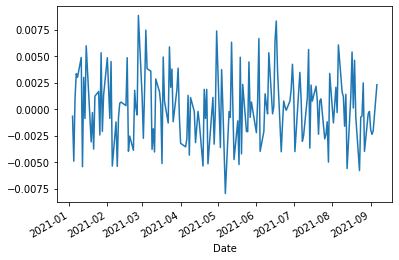

In [93]:
raw_data.loc['2021'].plot()

In [119]:
result

,Prediction,Ground_truth
0,-0.003548,True
1,0.001139,True
2,-0.001500,True
3,-0.006583,True
4,-0.002508,True
...,...,...
123,-0.002068,True
124,0.002926,True
125,-0.000334,True
126,-0.005957,True
